# Initializiation

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/MSBA/BA890/data

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/MSBA/BA890/data


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsRegressor


In [3]:
! ls

ingr_map.pkl		interactions_validation.csv  RAW_interactions.csv
interactions_test.csv	PP_recipes.csv		     RAW_recipes.csv
interactions_train.csv	PP_users.csv


In [4]:
df_recipes = pd.read_csv('RAW_recipes.csv')
df_interact = pd.read_csv('RAW_interactions.csv')
train_interact = pd.read_csv('interactions_train.csv')

In [5]:
df_recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


In [6]:
df_interact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1132367 non-null  int64 
 1   recipe_id  1132367 non-null  int64 
 2   date       1132367 non-null  object
 3   rating     1132367 non-null  int64 
 4   review     1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


In [7]:
train_interact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698901 entries, 0 to 698900
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    698901 non-null  int64  
 1   recipe_id  698901 non-null  int64  
 2   date       698901 non-null  object 
 3   rating     698901 non-null  float64
 4   u          698901 non-null  int64  
 5   i          698901 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 32.0+ MB


In [8]:
# join recipes on interactions to see which recipes are most popular
df = pd.merge(train_interact, df_recipes[['name','id']], left_on='recipe_id', right_on='id')
del df['id']

In [9]:
df.head()

,user_id,recipe_id,date,rating,u,i,name
0,2046,4684,2000-02-25,5.0,22095,44367,flank steak with lime chipotle sauce
1,12882,4684,2002-03-13,5.0,10399,44367,flank steak with lime chipotle sauce
2,37758,4684,2002-06-17,5.0,4954,44367,flank steak with lime chipotle sauce
3,37636,4684,2003-05-08,5.0,831,44367,flank steak with lime chipotle sauce
4,54697,4684,2003-06-30,5.0,1147,44367,flank steak with lime chipotle sauce


# Non-personalized Recommendations

This method will recommend recipes based on combiniations of recipes reviewers have cooked/reviewed over time. For example, if many reviewers cooked and reviewed a chicken pot pie recipe and an omelette recipe in the past, the omelette recipe may be recommended the next time someone views the chicken pot pie recipe.

In [10]:
df.shape

(698901, 7)

In [11]:
# had to drop observations due to RAM limitations
df2 = df.copy().sample(100000, random_state=1)
df2.shape

(100000, 7)

In [12]:
from itertools import permutations

# Create the function to find all permutations
def find_recipe_pairs(x):
  pairs = pd.DataFrame(list(permutations(x.values, 2)),
                       columns=['recipe_a', 'recipe_b'])
  return pairs

# Apply the function to the title column and reset the index
recipe_combinations = df2.groupby('user_id')['recipe_id'].apply(
  find_recipe_pairs).reset_index(drop=True)

print(recipe_combinations)

        recipe_a recipe_b
0         114839    37252
1         114839    72631
2         114839    22846
3         114839    14419
4         114839    35346
...          ...      ...
8118857    34110    33919
8118858    12058   388386
8118859   388386    12058
8118860     7359   429306
8118861   429306     7359

[8118862 rows x 2 columns]


In [13]:
combination_counts = recipe_combinations.groupby(['recipe_a', 'recipe_b']).size()

# Convert the results to a DataFrame and reset the index
combination_counts_df = combination_counts.to_frame(name='size').reset_index()
combination_counts_df.sort_values('size', ascending=False, inplace=True)
combination_counts_df.head()

,recipe_a,recipe_b,size
462447,27208,32204,8
580426,32204,27208,8
463135,27208,89204,7
1741229,89204,27208,7
462548,27208,39087,6


Lets see what happens when we want to recommend the most reviewed recipe (best banana bread, id = 2886)

In [14]:
banana_bread = combination_counts_df[combination_counts_df['recipe_a'] == 2886]
banana_bread = pd.merge(banana_bread, df_recipes[['id','name']], how='inner', left_on='recipe_b', right_on = 'id')
banana_bread = banana_bread.rename(columns={'name':'recommendation'})
del banana_bread['id']
banana_bread.head(10)

,recipe_a,recipe_b,size,recommendation
0,2886,68091,2,fake rotisserie chicken
1,2886,66976,2,creamy garlic chicken
2,2886,59056,2,lil cheddar meatloaves
3,2886,46739,2,tsr version of applebee s honey grilled salmon...
4,2886,42883,2,mom s beef roast
5,2886,39087,2,creamy cajun chicken pasta
6,2886,30081,2,ground beef gyros
7,2886,22856,2,creamy mexican dip
8,2886,90246,1,baked french toast casserole with maple syrup
9,2886,90024,1,black bean and cheesy burrito ww


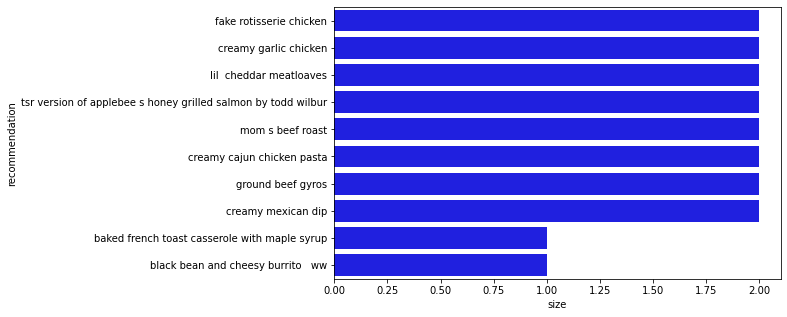

In [15]:
plt.figure(figsize=(8,5))
sns.barplot(data=banana_bread.head(10), x='size', y='recommendation', color = 'blue');

Based on this non-personalized recommendation system, those who enjoyed making the banana bread may chose to cook: 
* fake rotisserie chicken
* creamy garlic chicken
* lil cheddar meatloaves
* mom's beef roast

In [16]:
combination_counts_df.tail(15)

,recipe_a,recipe_b,size
2706322,135390,319193,1
2706309,135390,308090,1
2706321,135390,317320,1
2706320,135390,317037,1
2706319,135390,316070,1
2706318,135390,314669,1
2706317,135390,314087,1
2706316,135390,313576,1
2706315,135390,313086,1
2706314,135390,312155,1


With that said, this method may not work for recipes with very limited combinitations (or none). It may present a 'cold start' problem for recipes that are new and have not been reviewed by other users.